In [ ]:
import numpy as np
import pandas as pd

In [ ]:
!pip install nltk
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:

file_path = '/content/drive/My Drive/NYT/NYT_Dataset.csv'


In [ ]:
from google.colab import drive
drive.mount('/content/drive')





Mounted at /content/drive


In [ ]:
!cp '/content/drive/My Drive/NYT/attention.py' .
from attention import AttentionLayer

In [ ]:
from attention import AttentionLayer

In [ ]:
articles = pd.read_csv(file_path)
articles = articles[['title','topic','abstract','keywords']]
# articles = articles.sample(n=500, random_state=26).reset_index()

In [ ]:
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [ ]:
display(articles)

,title,topic,abstract,keywords
0,"In Reversal, Pakistan Welcomes Outside Help With Inquiry on Bhutto",Foreign,Pakistan’s ambassador to the U.S. said his government would not endorse a separate inquiry modeled after one carried out by the U.N. after the assassination of Rafik Hariri of Lebanon in 2005.,"['Assassinations and Attempted Assassinations', 'Pakistan', 'Bhutto, Benazir', 'Federal Bureau of Investigation', 'United Nations']"
1,Fighting Intensifies After Election in Kenya,Foreign,"Kenya sank deeper into trouble, with a curfew imposed in Kisumu, the country’s third-largest city, ethnic fighting intensifying and more than 100 people killed in election-related violence.","['Kenya', 'Demonstrations and Riots', 'Odinga, Raila', 'Kibaki, Mwai', 'Elections']"
2,Israel: Olmert Curbs Settlements,Foreign,"Prime Minister Ehud Olmert has sent a letter to defense, housing and agriculture ministers, saying that his and the defense minister’s authorization would be required for any new building, plannin...",['West Bank']
3,Gay Muslims Pack a Dance Floor of Their Own,Foreign,The monthly club night known as Gayhane is an all-too-rare opportunity for gay Muslims to merge their immigrant cultures and their sexual identities.,"['Homosexuality', 'Islam', 'IMMIGRATION AND REFUGEES', 'Berlin (Germany)']"
4,Iraqi Revelers Embrace the New Year,Foreign,"But even as partygoers embraced the New Year, a surge of attacks on Monday served as a potent reminder that 2007 was the bloodiest on record.","['ARMAMENT, DEFENSE AND MILITARY FORCES', 'Iraq']"
...,...,...,...,...
106501,BAFTA Suspends Award for Actor Noel Clarke Amid Harassment Allegations,Foreign,"The British actor and director has been accused of sexual assault, harassment and bullying by 20 women in a published report.","['Sexual Harassment', 'Actors and Actresses', 'British Academy of Film and Television', 'Guardian (British Newspaper)', 'Great Britain']"
106502,The Bureaucrat From Buffalo Who Pushed Somalia to the Brink,Foreign,"His bid to stay in office an extra two years, without elections, has led to gunfights in the capital and fears that Somalia is backsliding into a disastrous conflict.","['Mohamed, Mohamed Abdullahi', 'Mogadishu (Somalia)', 'Somalia', 'Blinken, Antony J', 'Somali-Americans', 'Politics and Government', 'Buffalo (NY)']"
106503,What to Know About the Census Data,U.S.,The count reflects the slowest population growth since the 1930s. It also offers a glimpse of the shifting centers of population and power in the United States.,"['Census', 'Population', 'United States', 'Race and Ethnicity', 'Immigration and Emigration', 'North Dakota', 'Midwestern States (US)', 'Northeastern States (US)', 'Western States (US)', 'Southern..."
106504,"After 500 Years, an Ancient Bronze Hand Is Rejoined to a Finger",Foreign,"Researchers still don’t know how a finger belonging to a colossal statue of Emperor Constantine went missing, but this week, it was finally reattached in Rome.","['Art', 'Roman Civilization', 'Capitoline Museums', 'Louvre Museum', 'Rome (Italy)']"


In [ ]:
import re
# get NLTK libraries
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

stop_words = set(stopwords.words('english'))

def clean_text(text, remove_stopwords = True):
    # Simple text break
    # data cleaning

    text = re.sub("(\\t)", ' ', str(text)).lower() #remove escape charecters
    text = re.sub("(\\r)", ' ', str(text)).lower()
    text = re.sub("(\\n)", ' ', str(text)).lower()

    text = re.sub("(__+)", ' ', str(text)).lower()   #remove _ if it occors more than one time consecutively
    text = re.sub("(--+)", ' ', str(text)).lower()   #remove - if it occors more than one time consecutively
    text = re.sub("(~~+)", ' ', str(text)).lower()   #remove ~ if it occors more than one time consecutively
    text = re.sub("(\+\++)", ' ', str(text)).lower()   #remove + if it occors more than one time consecutively
    text = re.sub("(\.\.+)", ' ', str(text)).lower()   #remove . if it occors more than one time consecutively

    text = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(text)).lower() #remove <>()|&©ø"',;?~*!

    text = re.sub("(mailto:)", ' ', str(text)).lower() #remove mailto:
    text = re.sub(r"(\\x9\d)", ' ', str(text)).lower() #remove \x9* in text
    text = re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(text)).lower() #replace INC nums to INC_NUM
    text = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM', str(text)).lower() #replace CM# and CHG# to CM_NUM


    text = re.sub("(\.\s+)", ' ', str(text)).lower() #remove full stop at end of words(not between)
    text = re.sub("(\-\s+)", ' ', str(text)).lower() #remove - at end of words(not between)
    text = re.sub("(\:\s+)", ' ', str(text)).lower() #remove : at end of words(not between)

    text = re.sub("(\s+.\s+)", ' ', str(text)).lower() #remove any single charecters hanging between 2 spaces
    text = re.sub("(\s+)",' ',str(text)).lower() #remove multiple spaces

    #Sho uld always be last
    text = re.sub("(\s+.\s+)", ' ', str(text)).lower() #remove any single charecters hanging between 2 spaces

    if remove_stopwords:
        tokens = [w for w in text.split() if not w in stop_words]
    else:
        tokens=text.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)
    return (" ".join(long_words)).strip()
    return text

In [ ]:
from tqdm.notebook import tqdm
tqdm.pandas()
articles['Cleaned_abstract'] = articles['abstract'].progress_apply(clean_text)
articles['Cleaned_title'] = articles['title'].progress_apply(clean_text)

  0%|          | 0/106506 [00:00<?, ?it/s]

  0%|          | 0/106506 [00:00<?, ?it/s]

In [ ]:
display(articles['Cleaned_abstract'])

0                                                                       pakistan’s ambassador u.s said government would endorse separate inquiry modeled one carried u.n assassination rafik hariri lebanon 2005.
1                                                          kenya sank deeper trouble curfew imposed kisumu country’s third-largest city ethnic fighting intensifying 100 people killed election-related violence.
2         prime minister ehud olmert sent letter defense housing agriculture ministers saying defense minister’s authorization would required new building planning land expropriation jewish settlements west...
3                                                                                               monthly club night known gayhane all-too-rare opportunity gay muslims merge immigrant cultures sexual identities.
4                                                                                                            even partygoers embraced new year surge attacks mon

In [ ]:
display(articles['Cleaned_title'])

0                                  reversal pakistan welcomes outside help inquiry bhutto
1                                                     fighting intensifies election kenya
2                                                         israel olmert curbs settlements
3                                                            gay muslims pack dance floor
4                                                         iraqi revelers embrace new year
                                               ...                                       
106501                 bafta suspends award actor noel clarke amid harassment allegations
106502                                            bureaucrat buffalo pushed somalia brink
106503                                                                   know census data
106504                                      500 years ancient bronze hand rejoined finger
106505    indoor dining new york city expand 75 percent capacity next week governor says.
Name: Clea

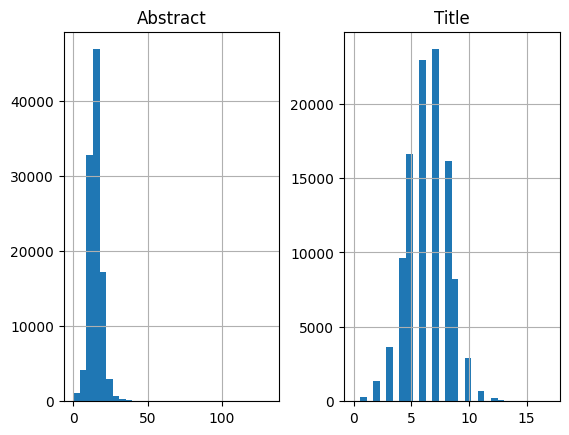

In [ ]:
import matplotlib.pyplot as plt

abstract_word_count = []
title_word_count = []

# populate the lists with sentence lengths
for i in articles['Cleaned_abstract']:
      abstract_word_count.append(len(i.split()))

for i in articles['Cleaned_title']:
      title_word_count.append(len(i.split()))

length_df = pd.DataFrame({'Abstract':abstract_word_count, 'Title':title_word_count})

length_df.hist(bins = 30)
plt.show()

In [ ]:
cnt=0
for i in articles['Cleaned_title']:
    if(len(i.split())<=9):
        cnt=cnt+1
print(cnt/len(articles['Cleaned_title']))

0.9627063264041462


In [ ]:
max_abstract_len=30
max_title_len=9

In [ ]:
cleaned_abstract = np.array(articles['Cleaned_abstract'])
cleaned_title = np.array(articles['Cleaned_title'])

short_abstract=[]
short_title=[]

for i in range(len(cleaned_abstract)):
    if(len(cleaned_title[i].split())<=max_title_len and len(cleaned_abstract[i].split())<=max_abstract_len):
        short_abstract.append(cleaned_abstract[i])
        short_title.append(cleaned_title[i])

df=pd.DataFrame({'abstract':short_abstract,'title':short_title})

In [ ]:
df['title'] = df['title'].progress_apply(lambda x : 'sostok '+ x + ' eostok')

  0%|          | 0/101936 [00:00<?, ?it/s]

In [ ]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['abstract']),np.array(df['title']),test_size=0.1,random_state=26,shuffle=True)

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

In [ ]:
thresh=2

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 42.57675073140022
Total Coverage of rare words: 1.6842879389630576


In [ ]:
#prepare a tokenizer for reviews on training data
# x_tokenizer = Tokenizer(num_words=tot_cnt-cnt, oov_token='<unk>')
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr)
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_abstract_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_abstract_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [ ]:
x_voc

31013

In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

In [ ]:
thresh=2

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 42.747579610404756
Total Coverage of rare words: 1.8867098863392113


In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences (i.e one hot encode the text in Y)
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr)
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val)

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_title_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_title_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1
print("Size of vocabulary in Y = {}".format(y_voc))

Size of vocabulary in Y = 19634


In [ ]:
y_tokenizer.word_counts['sostok'],len(y_tr)

(91742, 91742)

In [ ]:
# deleting the rows that contain only START and END tokens
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [ ]:
# deleting the rows that contain only START and END tokens
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [ ]:
from gensim.models import KeyedVectors

# Path to your Word2Vec binary file on Google Drive
path_to_word2vec = '/content/drive/My Drive/NYT/GoogleNews-vectors-negative300.bin.gz'

from gensim.models import KeyedVectors

# Load the Word2Vec model directly from the compressed .gz file
word2vec_model = KeyedVectors.load_word2vec_format(path_to_word2vec, binary=True)



In [ ]:
import numpy as np

embedding_dim = 300  # Google News vectors are of this dimension
vocab_size = len(x_tokenizer.word_index) + 1  # Plus one for the padding token

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in x_tokenizer.word_index.items():
    try:
        embedding_vector = word2vec_model[word]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    except KeyError:
        continue  # Words not found in the embedding index will be all zeros.


In [ ]:
from attention import AttentionLayer
from keras import backend as K
K.clear_session()

latent_dim = 300
embedding_dim = 300

# Encoder
encoder_inputs = Input(shape=(max_abstract_len,))
vocab_size = len(x_tokenizer.word_index) + 1


#embedding layer
enc_emb = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], trainable=False)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

print(type(decoder_outputs))
print(isinstance(decoder_outputs, type(encoder_outputs)))
print(decoder_outputs.shape)
print(type(decoder_outputs.shape))

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

<class 'keras.src.engine.keras_tensor.KerasTensor'>
True
(None, None, 300)
<class 'tensorflow.python.framework.tensor_shape.TensorShape'>
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 30, 300)              1620210   ['input_1[0][0]']             
                                                          0                                       
                                                                                                  
 lstm (LSTM)                 [(None, 30, 300),            721200    ['embedding[0][0]']           
                              (None, 300),             

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [ ]:
#model.load_weights('LSTM_100k_attention_no_stopwords.weights.h5')
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/50
717/717 [==============================] - 318s 413ms/step - loss: 6.3912 - val_loss: 5.9550
Epoch 2/50
717/717 [==============================] - 289s 402ms/step - loss: 5.8845 - val_loss: 5.6476
Epoch 3/50
717/717 [==============================] - 290s 405ms/step - loss: 5.6412 - val_loss: 5.4638
Epoch 4/50
717/717 [==============================] - 288s 401ms/step - loss: 5.4759 - val_loss: 5.3452
Epoch 5/50
717/717 [==============================] - 291s 406ms/step - loss: 5.3396 - val_loss: 5.2678
Epoch 6/50
717/717 [==============================] - 291s 406ms/step - loss: 5.2211 - val_loss: 5.1893
Epoch 7/50
717/717 [==============================] - 290s 405ms/step - loss: 5.1124 - val_loss: 5.1404
Epoch 8/50
717/717 [==============================] - 282s 393ms/step - loss: 5.0111 - val_loss: 5.0767
Epoch 9/50
717/717 [==============================] - 271s 379ms/step - loss: 4.9141 - val_loss: 5.0291
Epoch 10/50
717/717 [==============================] - 276s 384m

In [ ]:
model.save_weights("LSTM_100k_attention_no_stopwords.weights.h5")

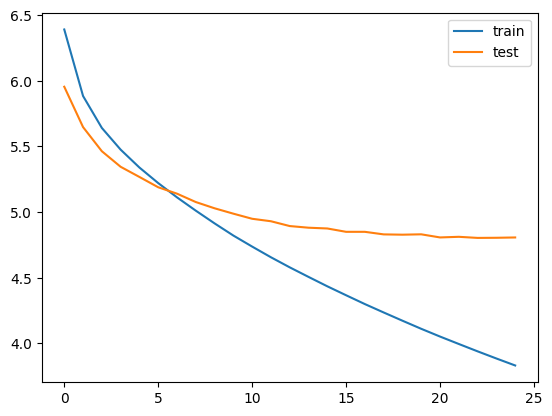

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_abstract_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_abstract_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2title(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2abstract(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
f = open('LSTM_attention.csv', 'w')
import csv
# create the csv writer
writer = csv.writer(f)

cols = ["Model", "Abstract", "True Title", "Predicted Title"]

# write a row to the csv file
writer.writerow(cols)

for i in range(len(x_val)):
    abstr = seq2abstract(x_val[i])
    print("Abstract:",abstr)
    truetitle = seq2title(y_val[i])
    print("Original Title:", truetitle)
    pred = decode_sequence(x_val[i].reshape(1,max_abstract_len))
    print("Predicted Title:",pred)
    writer.writerow(["LSTM Attention", abstr, truetitle, pred])
    f.flush()
    print("\n")
f.close()

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 23ms/step
Predicted Title:  canada ban new laws


Abstract: group released thursday morning held hostage nearly four months since kidnapped march cycling lebanon’s eastern valley 
Original Title: estonian hostages set free lebanon 
1/1 [==============================] - 0s 30ms/step
Predicted Title:  gunmen kill dozens killed pakistan


Abstract: archives international herald tribune charles de gaulle starts world tour august 1966 
Original Title: 1966 de gaulle taking world tour 
1/1 [==============================] - 0s 23ms/step
Predicted Title:  1891 dr king


Abstract: president hassan rouhani’s offer may gesture toward reducing escalating tensions iran west 
Original Title: suggesting tanker swap iran hints compromise 
1/1 [==============================] - 0s 26ms/step
Predicted Title:  iran’s leader says iran nuclear talks


Abstract: majority american voters support demonstrations poli

KeyError: 0